Run the following cell to import the required packages:

In [15]:
from itertools import product
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

### Breast Cancer Example
For our next example, we'll load a breast cancer dataset that classifies tumors as benign (0) or malignant(1).

In [16]:
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Let's load the dataset:

In [17]:
X = pd.DataFrame(cancer.data,
                 columns = cancer.feature_names)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


And perform the regression:

In [18]:
y = cancer.target

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X, y)
print(model.score(X,y))


0.9578207381370826


Our accuracy was 96%. To see exactly which ones were mislabeled, we can view a confusion matrix. We can see that fifteen benign tumors were incorrectly mislabeled as malignant and nine malignant tumors were incorrectly mislabeled as a benign.

In [19]:
model.fit(X, y)
confusion_matrix(y, model.predict(X))

array([[197,  15],
       [  9, 348]])

####  Cost Benefit Example: 

We can also optimize our models based on specific costs associated with our classification errors; here we will use specific dollar amounts as weights.

For this example let's assume that a true breast cancer positive early detection would 
save the company 100000 dollars in later treatment and legal fees, a false negative would cost the insurance company 50,000 in later treatment, a false positive would cost 500 dollars in more screening, and a true negative would cost the company 100 in screening fees.  

Then given the confusion matrix $[[198,  14], [  9, 348]]$ above, the expected value of offering the breast cancer screening would be:

\text{Expected_Value} = (100000)\#TPs + (-50000)\#FNs+(-500)\#FPs+(-100)\#TNs


### Accuracy, Recall, Precision, F Score
Let's get into a bit more specifics about what types of errors we can make.

![title](images/errors.png)

**Accuracy** is the one we are most used to. It is defined as:

$\text{Accuracy} = \frac{\text{True Positive + True Negative}}{\text{True Positive + True Negative + False Positive + False Negative}}$

Or more simply, as:

$\text{Accuracy} = \frac{\text{Correct samples}}{\text{All samples}}$

In our iris example, 96% of our classifications were correct and 4% were incorrect.

Many times, though, accuracy may not be the best measure. For example, suppose that 1% of a sample has breast cancer and 99% doesn't. Let's say your model simply spits out that no one has breast cancer. Then your model is 99% accurate. Sounds pretty good, right? We should probably aim to do better.

Let's now define another measure of error, **recall** (also known as **sensitivity**).

$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

in other words:

$\text{Recall} = \frac{\text{True Positive Predictions}}{\text{All Positive samples}}$

Going back to the breast cancer example, recall answers the question "Out of all the (few) positive cases, how many did I actually find?" A model with high recall has a small number of false negatives.

Another measure of error is called **precision**.

$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$

in other words:

$\text{Precision} = \frac{\text{True Positives}}{\text{All samples predicted to be positive}}$

Going back to our breast cancer example, precision answers the question "Out of all cases I predicted as positive, how many times was I right?" A model with high precision has a small number of false positives.

Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12. When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are".


A model with high recall and low precision will have most positive examples correctly recognized (low false negative rate) but there will be a lot of false positives (probably scaring a lot of women unncessarily if we're talking about the breast cancer example).

A model with low recall and high precision will miss a lot of positive examples (high false negative rate) but those which we predict as positive are indeed positive (low false positive rate). This type of model would not scare women unnecessarily but would miss a lot of detections in women that did indeed have breast cancer.

We do have a third measure, called the **F1 score**, that balances precision and recall; it is the harmonic mean of the two:

$F_1 = 2* \frac{\text{precision}*\text{recall}}{\text{precision}+\text{recall}}$


The **support** is the number of samples of the true response that lie in that class.

Luckily, there is a scikit-learn function that gives us all of these measures:

In [27]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       212
           1       0.94      0.97      0.95       357

    accuracy                           0.94       569
   macro avg       0.94      0.93      0.94       569
weighted avg       0.94      0.94      0.94       569



Let's interpret this. 
- With a precision score of 96%, out of all cases predicted as benign, we were correct 96% of the time. With a recall score of 93%, out of all benign tumors, we found 93% of them.
- With a precision score of 96%, out of all cases predicted as malignant, we were correct 96% of the time. With a recall score of 97%, out of all malignant tumors, we found 97% of them.

### AUC-ROC Curves

If we wanted to we could interpret recall as the True Positive Rate (TPR). Recall that recall is given by:

$\text{Recall/TPR} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

Going back to the breast cancer example, recall answers the question "Out of all the (few) positive cases, how many did I actually find?"

Another measure of error will be specificity. **Specificity** is defined as:

$\text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives + False Positives}}$

Suppose in a product survey most people liked ice cream. Specificity answers the question "Out of all the (few) negative cases that didn't like ice cream, how many did I actually find?"

The False Positive Rate (FPR) is given by:

$\text{FPR} = 1- \text{Specificity} = \frac{\text{False Positives}}{\text{True Negatives + False Positives}}$

We can plot a model in ROC (Receiver Operating Characteristic) space by plotting the False Positive Rate against the True Positive Rate:

<img src="images/roc2.png" width="500">

The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). The (0,1) point is also called a perfect classification. A random guess would give a point along a diagonal line (the so-called line of no-discrimination) from the left bottom to the top right corners (regardless of the positive and negative base rates). An intuitive example of random guessing is a decision by flipping coins. As the size of the sample increases, a random classifier's ROC point tends towards the diagonal line. In the case of a balanced coin, it will tend to the point (0.5, 0.5). One can achieve any level of performance on this line by flipping a weighted coin to decide between two categories.

The diagonal divides the ROC space. Points above the diagonal represent good classification results (better than random); points below the line represent bad results (worse than random). Note that the output of a consistently bad predictor could simply be inverted to obtain a good predictor.

Let us look into four prediction results from 100 positive and 100 negative instances:

<img src="images/tables.png" width="600">

Plots of the four results above in the ROC space are given in the figure. The result of method A clearly shows the best predictive power among A, B, and C. The result of B lies on the random guess line (the diagonal line), and it can be seen in the table that the accuracy of B is 50%. However, when C is mirrored across the center point (0.5,0.5), the resulting method C′(top left, the ' is really hard to see) is even better than A. This mirrored method simply reverses the predictions of whatever method or test produced the C contingency table. Although the original C method has negative predictive power, simply reversing its decisions leads to a new predictive method C′ which has positive predictive power. When the C method predicts p or n, the C′ method would predict n or p, respectively. In this manner, the C′ test would perform the best. 

The logistic regression model we have been using set a 50% threshold for determining classifications. In the graphic below, if the probability was above 50%, then the object was classified as an apple:

<img src="images/apple.png" width="500">

If you wanted to reduce the false positive rate, you could move the threshold up (so that an object got classified as an apple only if the probability was above 70%, for example.) If you wanted to reduce the false negative rate, you could move the threshold down (so that an object got classified as an apple if the probability was above 30%, for example.) Each threshold is a different model. If you move that threshold from 0 to 1 then at each threshold value, you will have a certain TPR and a certain FPR. Plotting each coordinate gives you a model's ROC curve:

<img src="images/roc.png" width="300">

AUC is defined as the area under the ROC curve. A perfect model has AUC of the 1 which means it has good measure of separability. 

<img src="images/roc3.png" width="600">

In reality, though, most of our ROC curves will look more like this:

<img src="images/roc4.png" width="600">

We can compare models and choose the one with the highest AUC.

(source: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

Going back to our breast cancer example, let's do a test/train split and calculate the AUC score:
    

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

# accuracy for test & train:    
y_proba_LR = model.predict_proba(X_test)[:, 1]

# calculate AUC
print('accuracy:', model.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_LR))

accuracy: 0.9440559440559441
ROC-AUC: 0.9880165289256198


We can also view the ROC plot:

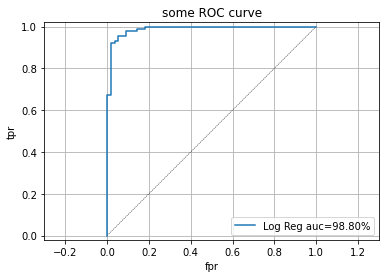

In [24]:
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    
plot_roc(y_test, y_proba_LR, "Log Reg")

## Gradient Boosting Classifier

A classifying technique that sometimes provides greater accuracy than logistic regression is the gradient boosting classifer. Let's try it out on the breast cancer dataset:

In [25]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# accuracy for test & train:    
y_proba_GB = model.predict_proba(X_test)[:, 1]

#calculate AUC
print('accuracy:', model.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_GB))

accuracy: 0.9370629370629371
ROC-AUC: 0.984090909090909


We can compare the Naive Bayes, logistic regression, and gradient boosting ROC curves:

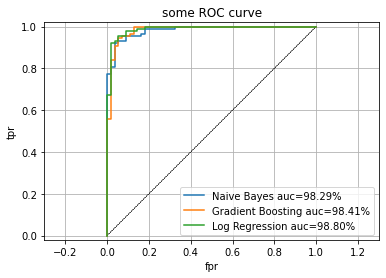

In [26]:
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
   
y_proba_NB = model.predict_proba(X_test)[:, 1]


plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")

### Homework - #1 Digits

Read in the digit example from yesterday. Do a 70/30 train/test split and then print a classification report for your logistic regression algorithm. Then, in words, write what the precision and recall scores that you get mean for the digits 1 and 8.

In [1]:
#insert 2

### HW #2 - Hyperthyroid

There is an excellent hyperthyroid example listed [here](http://gim.unmc.edu/dxtests/ROC1.htm) and [here](http://gim.unmc.edu/dxtests/roc2.htm).  List the accuracy, recall/sensitivity/true positive rate, precision, support, specificity, and false negative rate for each of the three threshold values. Also make sure you understand how the ROC curve is obtained. There will be a quiz on exactly this question with different numbers next week.

<img src="images/hyper2.png" width="300">
<img src="images/hyper1.png" width="300">
<img src="images/hyper3.png" width="300">
<img src="images/hyper5.png" width="300">
<img src="images/hyper4.png" width="300">

In [ ]:
# insert here